In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

#  Портфельная теория Марковица

В этом задании мы будем работать с данными по ценным бумагам. Мы немного поанализируем их и попробуем собрать оптимальный портфель.

- в таблице `stocks.csv` содержится информация об акциях нескольких компаний с $01.01.2014$ по $31.12.2023$ по дням.
- таблице `exchange_rates.csv` содержится информация о курсах валют _USD-RUB_, _EUR-RUB_ и _HKD-RUB_ за тот же период.

Подгрузим данные и посмотрим на них.

In [ ]:
df_stocks = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/stocks.csv')
print(df_stocks.shape)
df_stocks.head()

(17572, 8)


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,29.12.2023,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,28.12.2023,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,27.12.2023,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,26.12.2023,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,22.12.2023,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [ ]:
df_rates = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/exchange_rates.csv')
print(df_rates.shape)
df_rates.head()

(3652, 4)


,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,01.01.2014,"45,189","32,855","4,237"
1,02.01.2014,"45,254","33,1","4,269"
2,03.01.2014,"45,114","33,2","4,282"
3,04.01.2014,"45,125","33,248","4,288"
4,05.01.2014,"45,228","33,255","4,289"


## 1 Причешем данные

Часто при загрузке данных из каких-либо источников, особенно если они разные, у вас будет возникать необходимость в их форматировании. Поэтому в этой части потренируемся корректировать переменные для последующей работы с ними.


__а) [2 балла]__ В колонке `'Дата'` лежат дни, в которые осуществлялась торговля акциями. Превратите её в формат `datetime` в обеих таблицах.

In [ ]:
# your code here
# (♡-_-♡)
df_stocks['Дата'] = pd.to_datetime(df_stocks['Дата'])

df_stocks.head()


<ipython-input-216-53bf273b100a>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_stocks['Дата'] = pd.to_datetime(df_stocks['Дата'])


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,2023-12-28,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,2023-12-27,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,2023-12-26,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,2023-12-22,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [ ]:
df_rates['Дата'] = pd.to_datetime(df_rates['Дата'])

df_rates.head()

<ipython-input-217-08f51e5155f2>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_rates['Дата'] = pd.to_datetime(df_rates['Дата'])


,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-01,"45,189","32,855","4,237"
1,2014-02-01,"45,254","33,1","4,269"
2,2014-03-01,"45,114","33,2","4,282"
3,2014-04-01,"45,125","33,248","4,288"
4,2014-05-01,"45,228","33,255","4,289"


__б) [5 баллов]__ Для продолжения работы необходимо перевести столбцы в числовой формат, однако они содержат некорректные символы, которые не позволят сделать это напрямую.

Допишите функцию, которая примет на вход тип данных `string` и:

- Уберет лишнюю точку, разделяющую тысячные разряды в числах (например, $2.024,01 \rightarrow 2024,01$)
- Заменит символ запятой, отделяющий десятичный разряд, на точку (например, $2024,01 \rightarrow 2024.01$)
- Уберет символы `%`, `'B'` (млрд), `'M'` (млн) и `'K'` (тыс)
- Затем изменит тип данных с `string` на `float`
- И домножит на $10^9$, если в исходном значении содержалась `'B'`, на $10^6$, если `'M'`, или на $10^3$, если `'K'`.

In [ ]:
def correct_values(value: str):

    corrected_value = value.replace('.', '').replace(',', '.')
    corrected_value = corrected_value.replace('%', '').replace('B', '').replace('M', '').replace('K', '')


    corrected_value = float(corrected_value)

    if 'B' in value:
        corrected_value *= 10**9
    elif 'M' in value:
        corrected_value *= 10**6
    elif 'K' in value:
        corrected_value *= 10**3

    return corrected_value

In [ ]:
correct_values("194,40")

194.4

Примените данную функцию к столбцам `'Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'` таблицы `df_stocks` и к столбцам `'EUR_RUB', 'USD_RUB', 'HKD_RUB'` таблицы `df_rates`.

__Hint:__ Для этого можно использовать метод `map` библиотеки `pandas`. Важно также указать параметр `na_action='ignore'`, чтобы пустые значения не передавались в функцию `correct_values`, [(ссылка на документацию).](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html)

In [ ]:
st_col = ['Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %']
rt_col = ['EUR_RUB', 'USD_RUB', 'HKD_RUB']
for i in st_col:
    df_stocks[i] = df_stocks[i].map(correct_values, na_action='ignore')

df_stocks.head()


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL


In [ ]:
for i in rt_col:
    df_rates[i] = df_rates[i].map(correct_values, na_action='ignore')
df_rates.head()

,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-01,45.189,32.855,4.237
1,2014-02-01,45.254,33.100,4.269
2,2014-03-01,45.114,33.200,4.282
3,2014-04-01,45.125,33.248,4.288
4,2014-05-01,45.228,33.255,4.289


__в) [5 баллов]__ Поскольку акции компаний торгуются на разных биржах, цены также указаны в различных валютах.
Давайте приведем все к рублям, используя таблицу `df_rates`. Для этого важно знать, что данные по тикерам:

- `'AAPL'` и `'MSFT'` собраны в долларах `USD`
- `'MBGn'` и `'BMWG'` $-$ в евро `EUR`
- `'Tencent'` $-$ в Гонконгских долларах `HKD`
- по остальным $-$ в `RUB`

Давайте сначала объединим таблицы, выполнив операцию `left join` таблицы `df_stocks` с `df_rates` по столбцу `'Дата'`. Для этого будем использовать метод `merge`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [ ]:
df_merged = df_stocks.merge(df_rates, on='Дата', how='left')
df_merged.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL,101.467,92.00,11.791


 Затем преобразуем столбцы `'Цена', 'Откр.', 'Макс.', 'Мин.'`, умножив их на соответствующий данной акции курс.

In [ ]:
stocks_currency_dict = {
    "AAPL": "USD_RUB",
    "MSFT": "USD_RUB",
    "MBGn": "EUR_RUB",
    "BMWG": "EUR_RUB",
    "Tencent": "HKD_RUB",
}

for ticker, curr_pair in stocks_currency_dict.items():

    df_merged.loc[df_merged['Тикер'] == ticker, ['Цена', 'Откр.', 'Макс.', 'Мин.']] = df_merged.loc[df_merged['Тикер'] == ticker, ['Цена', 'Откр.', 'Макс.', 'Мин.']].multiply(df_merged[curr_pair], axis=0)

df_merged.head()


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,17397.0108,17520.8040,17565.9840,17324.7228,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,17298.3088,17348.3504,17394.8176,17261.6712,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,17628.8005,17568.5623,17660.7450,17440.7843,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,17694.9630,17746.2926,17771.9574,17674.7978,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,17811.2000,17956.5600,17977.7200,17753.2400,37150000.0,-0.55,AAPL,101.467,92.00,11.791


Наконец, мы закончили с первичными преобразованиями и можем приступать к дальнейшему анализу.

## 2 Начало работы с данными

__а) [2 балла]__ Посмотрите наличие пропусков в данных таблицы `df_merged`. Информация по каким тикерам и за какой период отсутствует? Удалите строки с пропущенными данными.

In [ ]:
no_data = df_merged.isnull().any()

no_data

Дата       False
Цена       False
Откр.      False
Макс.      False
Мин.       False
Объём       True
Изм. %     False
Тикер      False
EUR_RUB    False
USD_RUB    False
HKD_RUB    False
dtype: bool

In [ ]:
missing  = df_merged[df_merged.isnull().any(axis=1)]
tickers = missing['Тикер'].unique()
print(tickers)
dates = missing['Дата'].unique()

print(dates)
df_merged.dropna(inplace=True)


df_merged.head()

['AAPL' 'BMWG' 'MBGn' 'Tencent']
['2016-02-27T00:00:00.000000000' '2022-11-21T00:00:00.000000000'
 '2022-03-05T00:00:00.000000000' '2022-02-05T00:00:00.000000000'
 '2022-04-05T00:00:00.000000000' '2022-04-25T00:00:00.000000000'
 '2015-01-17T00:00:00.000000000']


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,17397.0108,17520.8040,17565.9840,17324.7228,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,17298.3088,17348.3504,17394.8176,17261.6712,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,17628.8005,17568.5623,17660.7450,17440.7843,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,17694.9630,17746.2926,17771.9574,17674.7978,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,17811.2000,17956.5600,17977.7200,17753.2400,37150000.0,-0.55,AAPL,101.467,92.00,11.791


__б) [2 балла]__ Какое количество уникальных тикеров содержится в таблице `df_stocks`?

In [ ]:
# your code here
# (◕‿◕)♡
result = df_stocks['Тикер'].unique()

print(result)
print(len(result))

['AAPL' 'BMWG' 'GAZP' 'MBGn' 'MSFT' 'VTBR' 'Tencent']
7


__в) [2 балла]__  Для каких акций и в какой временной период была зафиксирована наибольшая разность между значениями `'Макс.'` и `'Мин.'` в рублях?

In [ ]:
df_merged['Разница'] = df_merged['Макс.'] - df_merged['Мин.']

result1 = df_merged.loc[df_merged['Разница'].idxmax()]
result1

Дата       2023-07-18 00:00:00
Цена                 32677.641
Откр.                31435.947
Макс.                33340.302
Мин.                 31103.253
Объём               64520000.0
Изм. %                    3.98
Тикер                     MSFT
EUR_RUB                102.184
USD_RUB                   90.9
HKD_RUB                 11.613
Разница               2237.049
Name: 10205, dtype: object

In [ ]:
print("Тикер:", result1['Разница'])
print("Тикер:", result1['Тикер'])
print("Дата:",result1['Дата'])

Тикер: 2237.048999999992
Тикер: MSFT
Дата: 2023-07-18 00:00:00


__г) [2 балла]__  В какие периоды было продано/куплено акций на наибольшую сумму рублей. Какие это были акции?

__Hint__: Объем — это количество проданных/купленных акций

In [ ]:
# your code here
# (⌒_⌒;)
vol = df_merged.groupby('Дата')['Объём'].sum()
# Возьмем 3 наибольших
maxx = vol.nlargest(3).index
for i in maxx:
    print(i, vol[i])

for i in maxx:

    res = df_merged[df_merged['Дата'] == i]

    unique_tickers = res['Тикер'].unique()
print(unique_tickers)

2023-04-27 00:00:00 703448046420.0
2023-03-20 00:00:00 674088570000.0
2023-10-08 00:00:00 649837335310.0
['AAPL' 'BMWG' 'GAZP' 'MBGn' 'MSFT' 'VTBR' 'Tencent']


__д) [5 баллов]__  В столбике `'Изм. %'` лежат изменения стоимости ценных бумаг в процентах. При этом для каждой бумаги валюта своя.

Найдите 5 дат, в которые наблюдались наибольшие средние процентные изменения стоимости акций в абсолютном выражении.

__Hint:__ От изменения акций надо взять модуль, а затем посчитать среднее по тикерам для каждой даты.

In [ ]:
df_merged['Изм. %'] = df_merged['Изм. %'].abs()
meann= df_merged.groupby('Дата')['Изм. %'].mean()

res2 = meann.nlargest(5)

res2


Дата
2022-02-24    13.081429
2016-02-29    11.840000
2020-03-24    10.795714
2020-12-03    10.615714
2022-02-21     9.128000
Name: Изм. %, dtype: float64

__е) [2 балла]__ Сохраните ответ в переменную `top_5_diff` в виде таблички:

| Дата     | Изм. % |
|----------|--------|
| 01/01/01 |   1   |
|    ...   |  ...  |
| 03/01/01 |   3   |

In [ ]:
top_5_diff = pd.DataFrame({'Дата': res2.index, 'Изм. %': res2.values})

top_5_diff


,Дата,Изм. %
0,2022-02-24,13.081429
1,2016-02-29,11.840000
2,2020-03-24,10.795714
3,2020-12-03,10.615714
4,2022-02-21,9.128000


__ё) [5 баллов]__ Далее мы будем работать только со средними ценами, поэтому имеет смысл перевести таблицу из длинного формата в широкий

Было:

| Дата     | Цена | Тикер |
|----------|------|-------|
| 01/01/01 |  10  |   A   |
| 02/01/01 |  20  |   A   |
| 03/01/01 |  30  |   A   |
|   ...    | ...  |  ...  |
| 01/01/01 |  15  |   B   |
| 02/01/01 |  30  |   B   |
| 03/01/01 |  60  |   B   |
|   ...    | ...  |  ...  |

Станет:

| Дата     | Цена A | Цена B | ... |
|----------|--------|--------|-----|
| 01/01/14 |   10   |   15   | ... |
| 02/01/14 |   20   |   30   | ... |
| 03/01/14 |   30   |   60   | ... |
|   ...    |  ...   |  ...   | ... |


Это можно сделать по-разному, например, с помощью `pivot_table` ([ссылка](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) на документацию)

In [ ]:
df = df_merged.pivot_table(index='Дата', columns='Тикер', values='Цена')

df.tail()

Тикер,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
2023-12-25,NaN,NaN,161.09,NaN,NaN,NaN,0.023195
2023-12-26,17694.9630,NaN,161.00,NaN,34341.3356,NaN,0.023160
2023-12-27,17628.8005,10218.61160,159.86,6378.48993,34141.3689,3343.3350,0.022875
2023-12-28,17298.3088,9834.98436,159.14,6096.43694,33535.0208,3318.2250,0.022695
2023-12-29,17397.0108,9936.50488,159.52,6167.17980,33978.9744,3355.5544,0.022680


In [ ]:
df.head()

Тикер,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
2014-01-04,677.92502,4451.26224,135.89,3371.43600,1451.89526,494.13366,0.03940
2014-01-05,752.44224,NaN,NaN,NaN,1425.08000,NaN,NaN
2014-01-07,803.29004,4385.00670,148.97,3251.86081,1438.56946,NaN,0.04106
2014-01-08,859.02444,4206.24000,131.50,2920.80000,1532.15928,574.02774,0.04000
2014-01-09,NaN,4304.56910,132.32,3026.55080,NaN,591.69376,0.03832


__ж) [5 баллов]__  Для всех тикеров из таблички `df` постройти картинки с динамикой цен во времени, а также нистограммы цен. Дайте ответы на вопросы:

- Распределение стоимости акций похоже на нормальное?
- Что происходило с финансовыми рынками в течение последних $10$ лет? Они росли? Они падали? Видно ли, что были кризисы?

__Ответ:__

1) Нельзя сказать, что у каких-то тикеров можно однозначно заметить нормальное распределение. Наиболее близким будет распределение для цен акций BMWG, MBGn
2) В основном можно заметить тенденцию роста цен на акции. Можно также обратить внимание, что в 2021-2023 произошел спад для большинства акций из нашей выборки(в это время и происходил кризис на финансовом рынке). Однако акции VTBR подали в течение всех 10 лет.

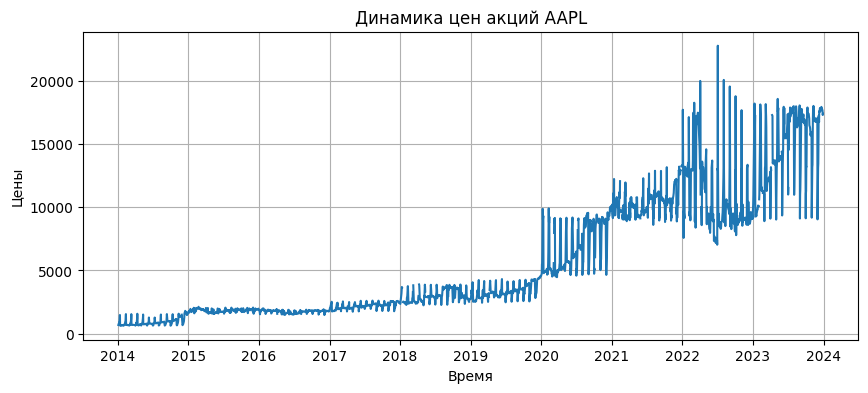

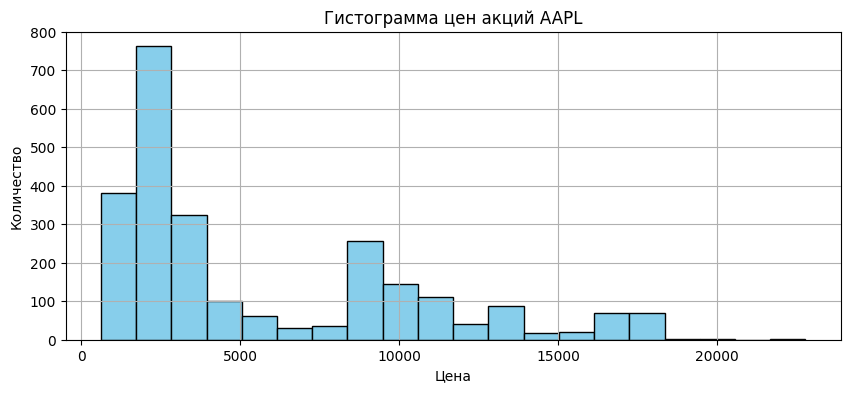

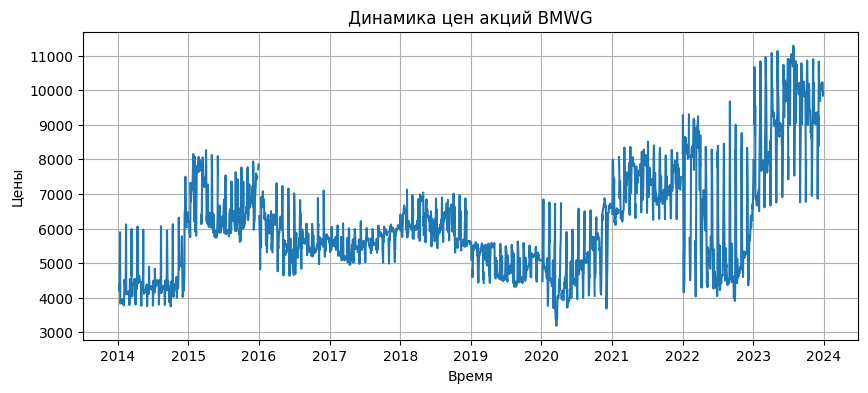

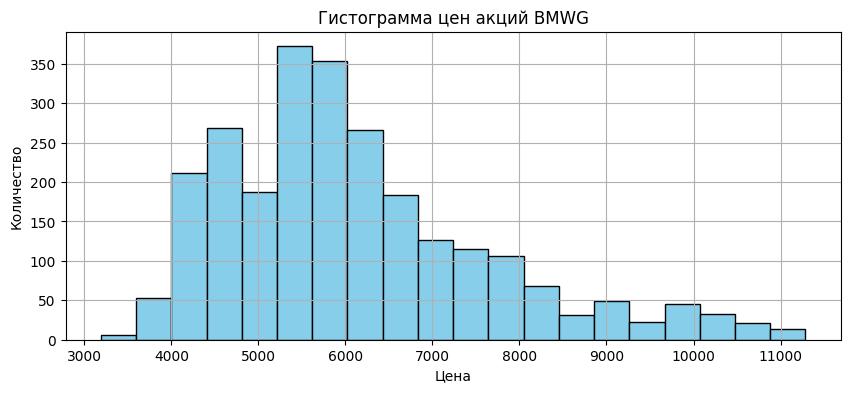

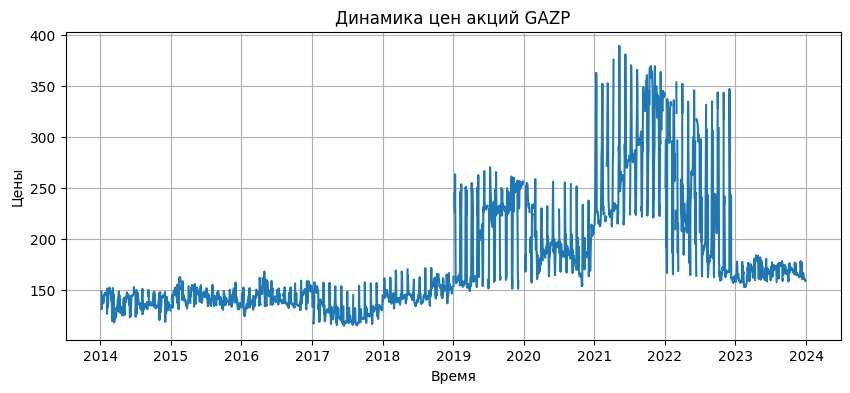

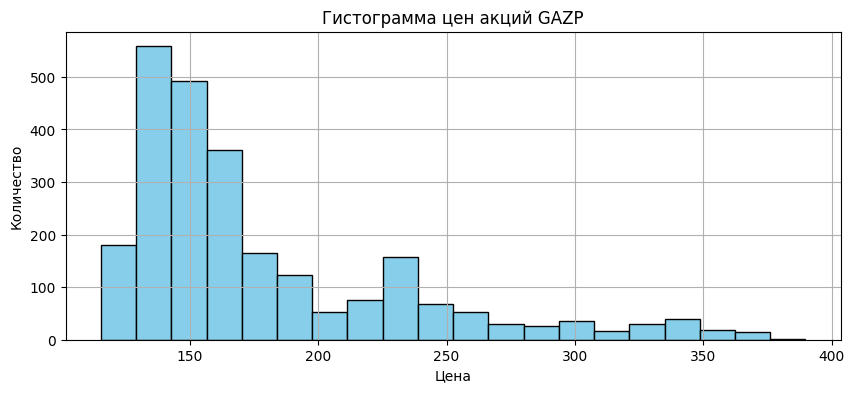

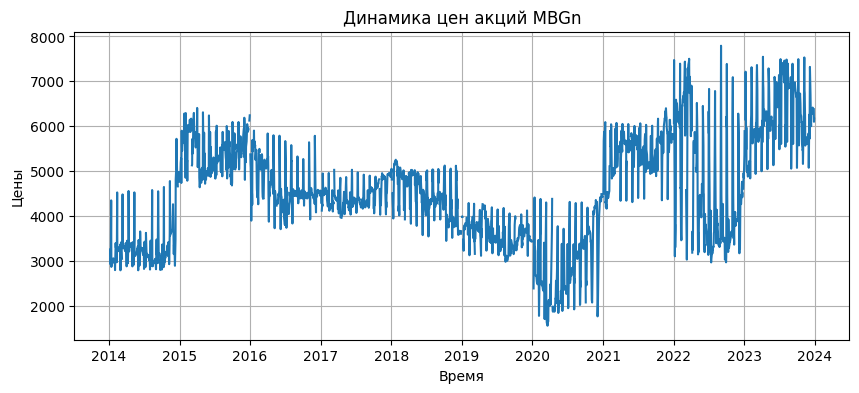

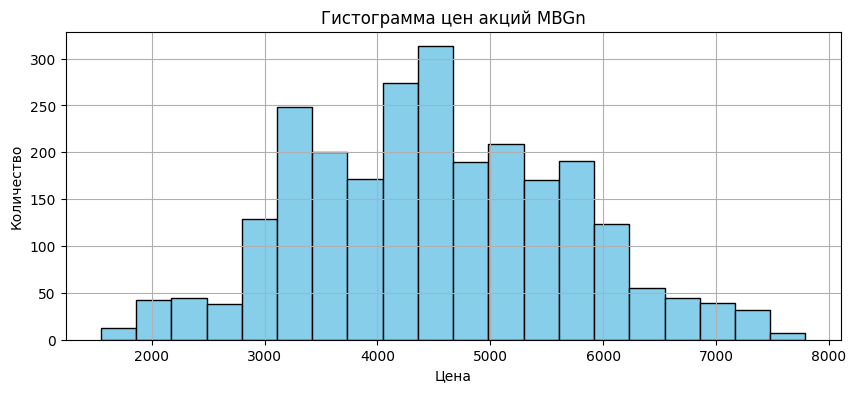

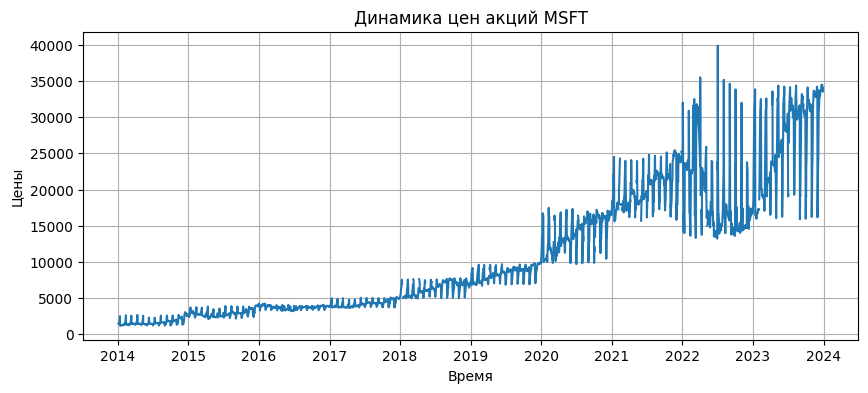

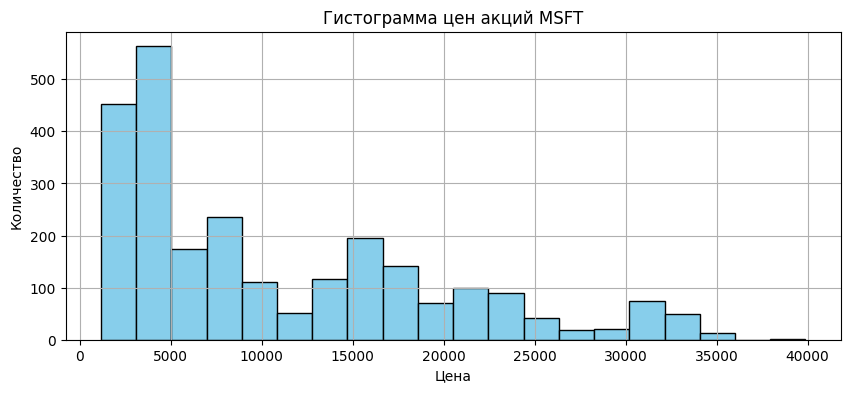

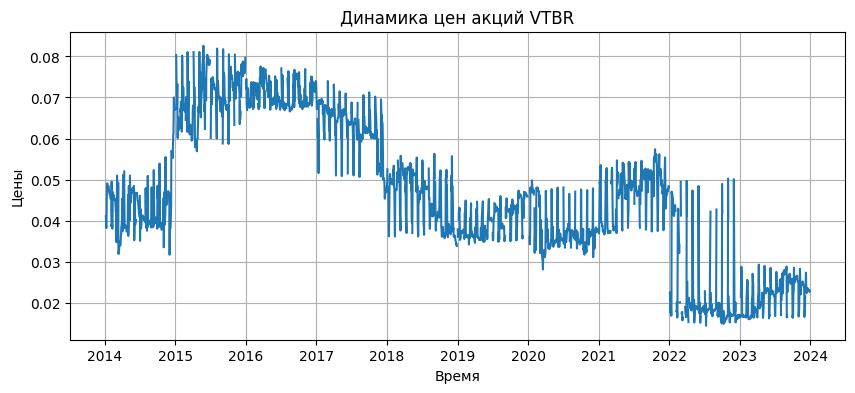

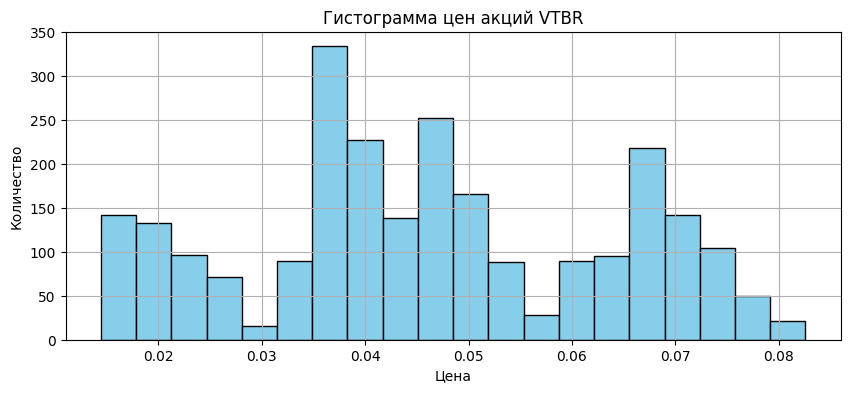

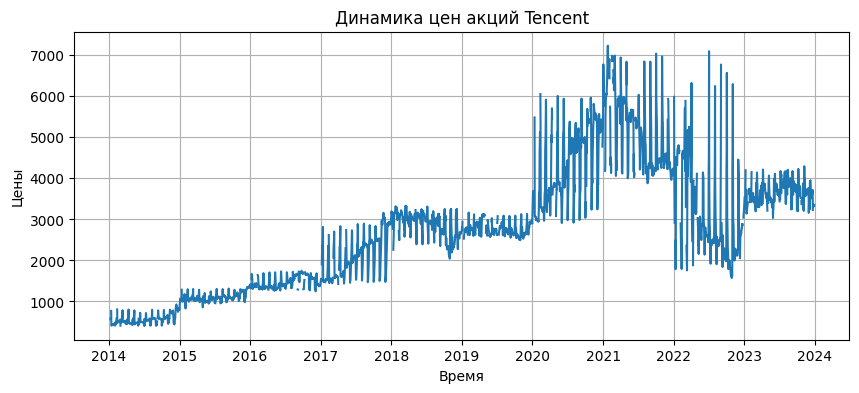

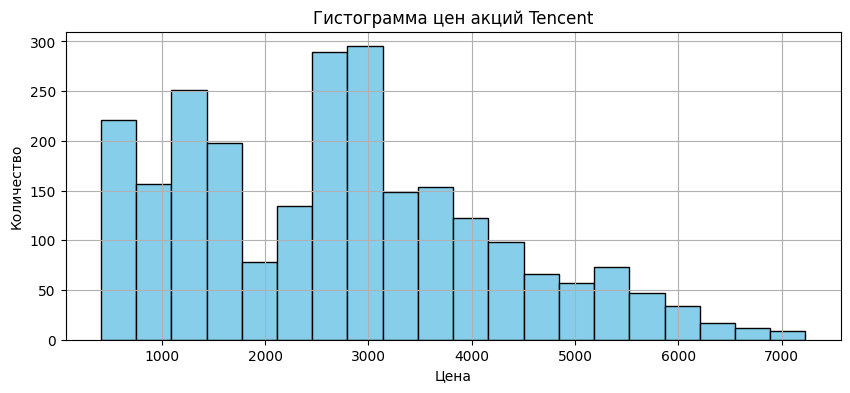

In [ ]:
cnt = ['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'VTBR' ,'Tencent']

for i in cnt:

    plt.figure(figsize=(10, 4))
    plt.plot(df[i])

    plt.title(f'Динамика цен акций {i}')

    plt.xlabel('Время')
    plt.ylabel('Цены')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 4))
    plt.hist(df[i], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Гистограмма цен акций {i}')
    plt.xlabel('Цена')
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()


Финансовые продукты описываются двумя характеристикам – __доходностью__ и __риском.__ Доходность – это процентное изменение стоимости за некоторый промежуток времени:

$$
R_t = \left( \frac{P_t}{P_{t-1}} - 1 \right) \cdot 100\%.
$$

Под риском обычно имеют в виду стандартное отклонение.


__з) [5 баллов]__  Рассчитайте процентное изменение цены акций в рублях ото дня ко дню для `df`. Полученную таблицу доходностей сохраните в переменную `df_pct_change`.

__Hint__: С этим поможет метод `pct_change()`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html)

In [ ]:
cnt = ['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'VTBR' ,'Tencent']
df_pct_change = df.pct_change()
df_pct_change1 = df.pct_change()
df_pct_change1= df_pct_change.reset_index()
for i in cnt:
    df_pct_change1[i]*= 100
df_pct_change1.head()


Тикер,Дата,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
0,2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-05,10.991956,0.000000,0.000000,0.000000,-1.846914,0.000000,0.000000
2,2014-01-07,6.757701,-1.488466,9.625432,-3.546714,0.946576,0.000000,4.213198
3,2014-01-08,6.938266,-4.076771,-11.727193,-10.180657,6.505756,16.168516,-2.581588
4,2014-01-09,0.000000,2.337696,0.623574,3.620611,0.000000,3.077555,-4.200000


__и) [5 баллов]__  Для всех тикеров из таблички `df_pct_change` постройти картинки с динамикой доходностей, гистограмму доходностей и ящики с усами. Ответьте на следующие вопроcы:

- Имеют ли доходности по акциям нормальное распределение?
- Видно ли по ящику с усами, что в данных довольно много выбросов?

__Ответ:__ ваш текст

1) Да, доходности по акциям имеют нормальное распределение. Это видно по их колокообразной форме. 2) Да, по графику ящика с усами видно, что в данных много выбросов.

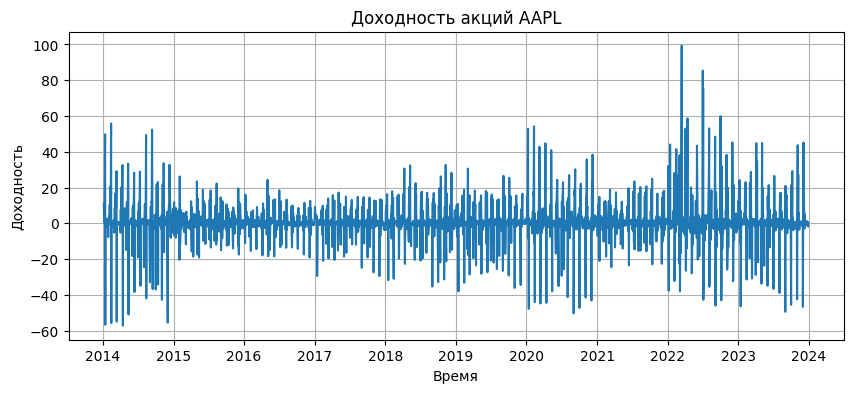

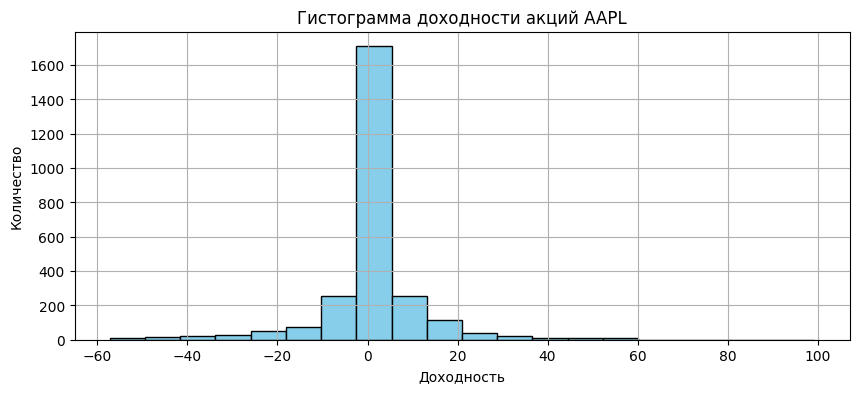

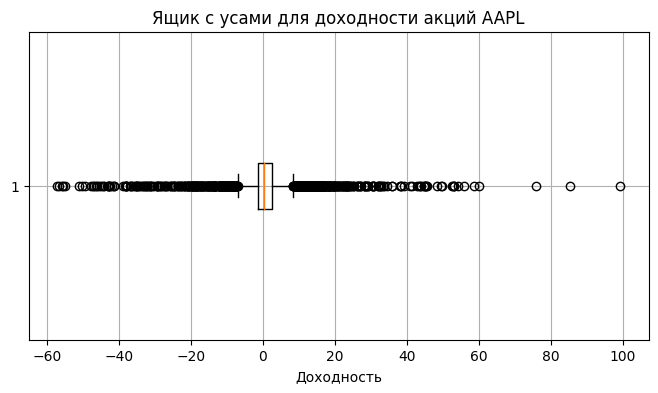

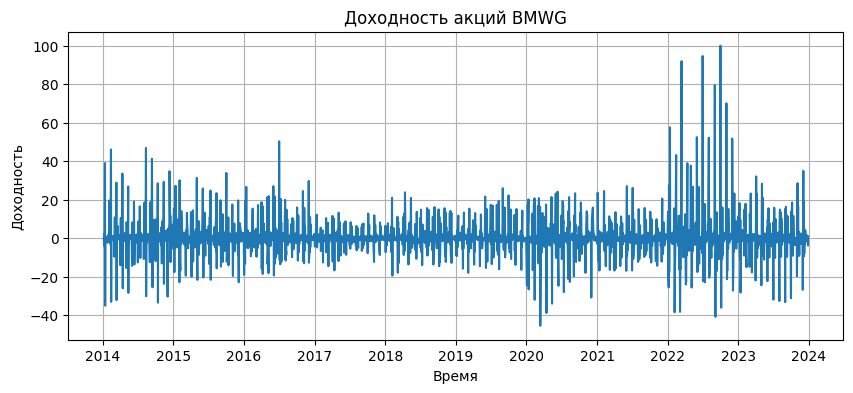

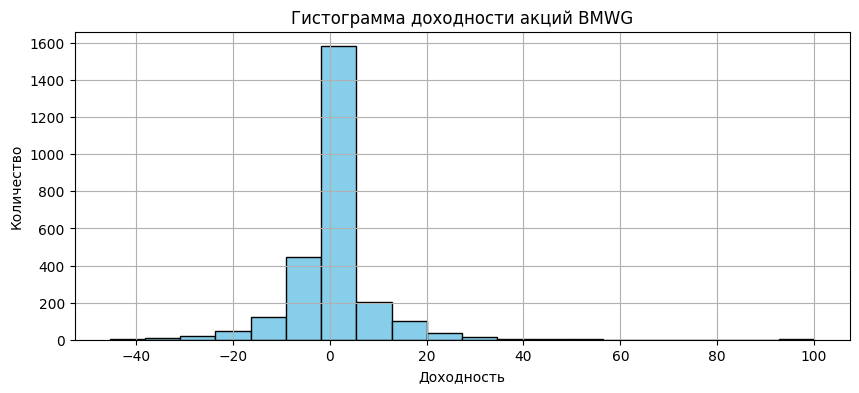

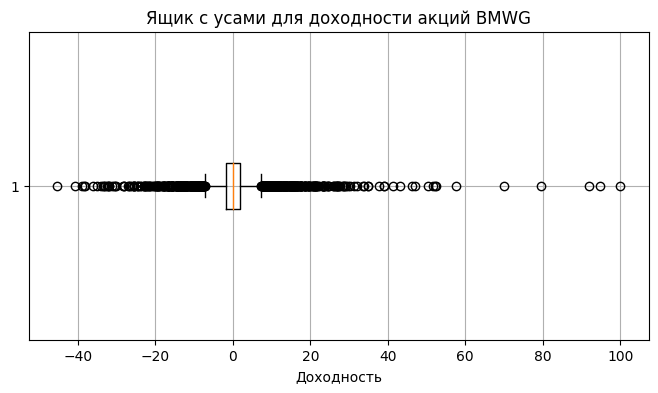

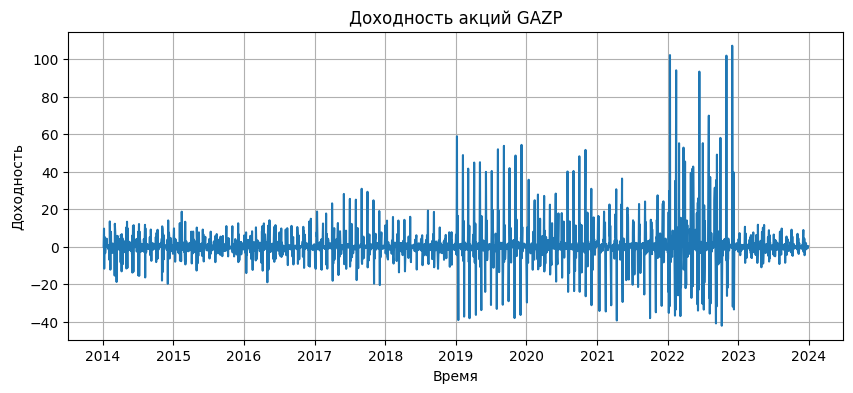

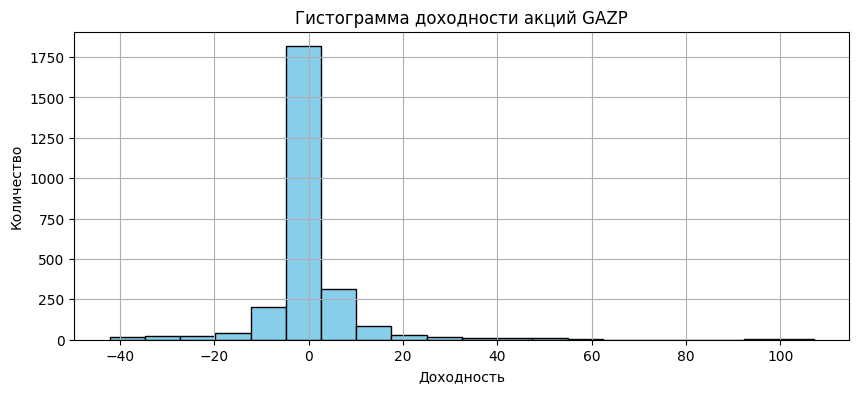

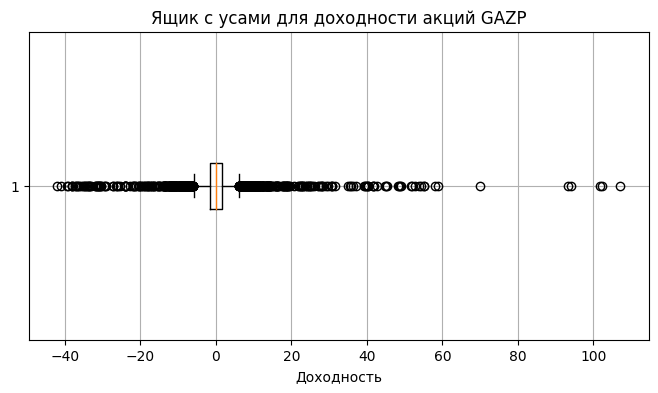

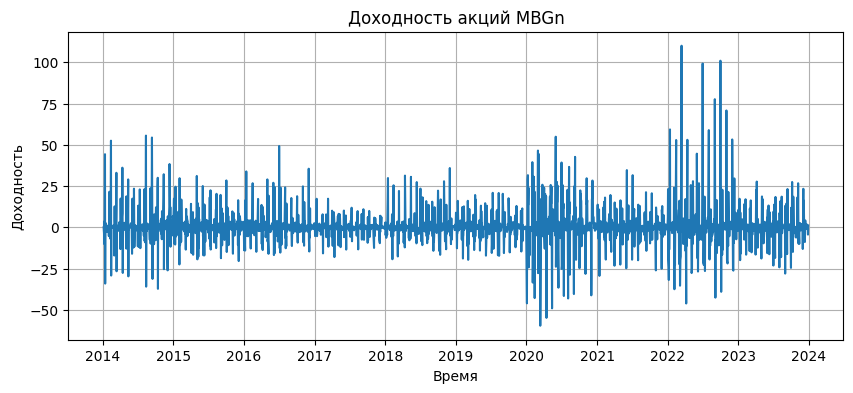

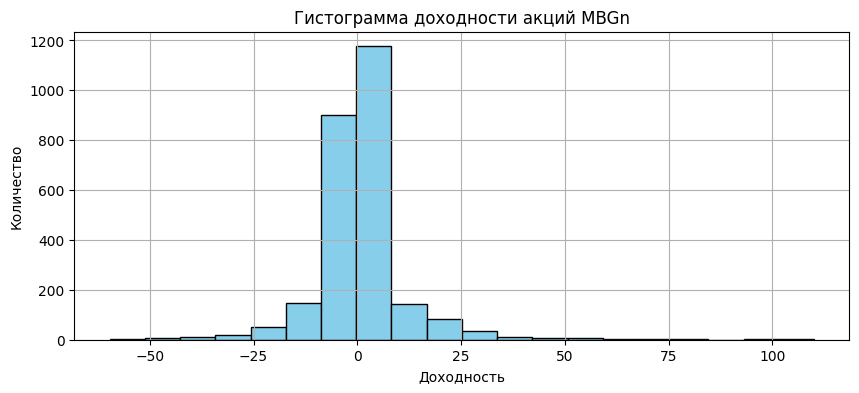

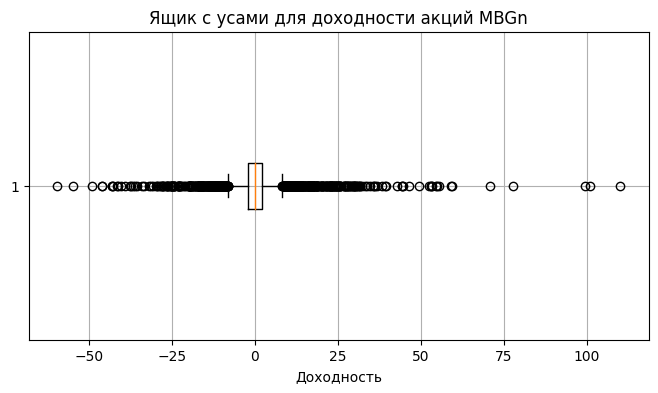

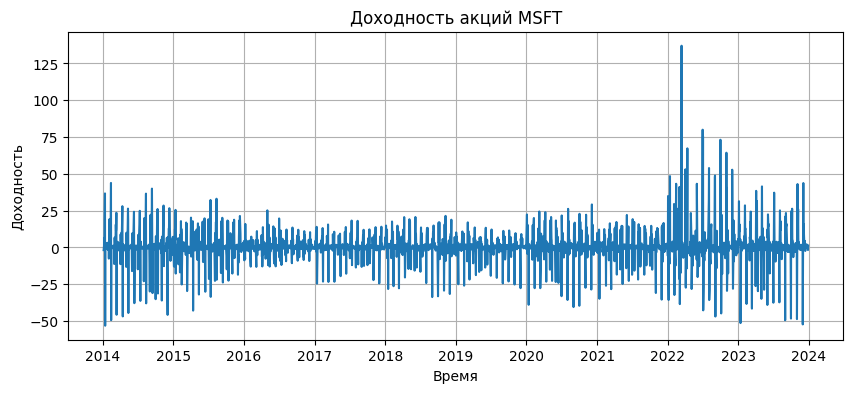

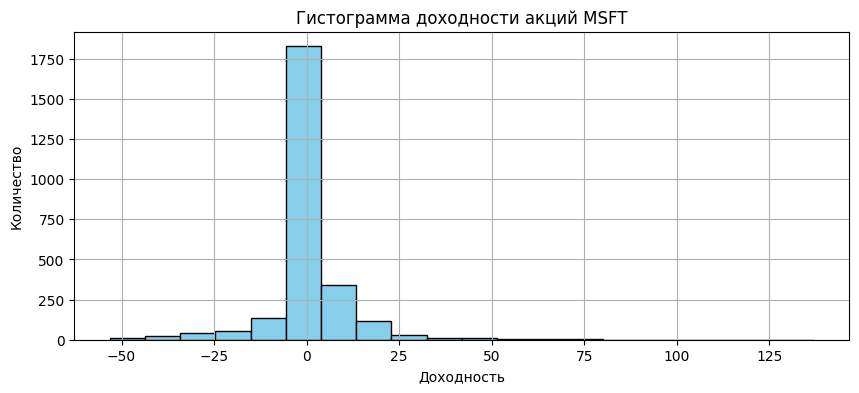

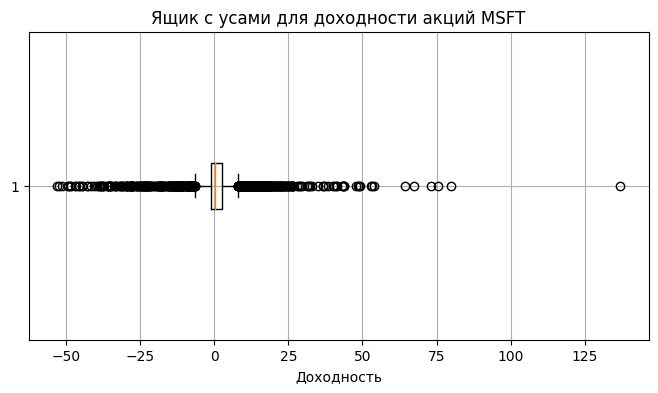

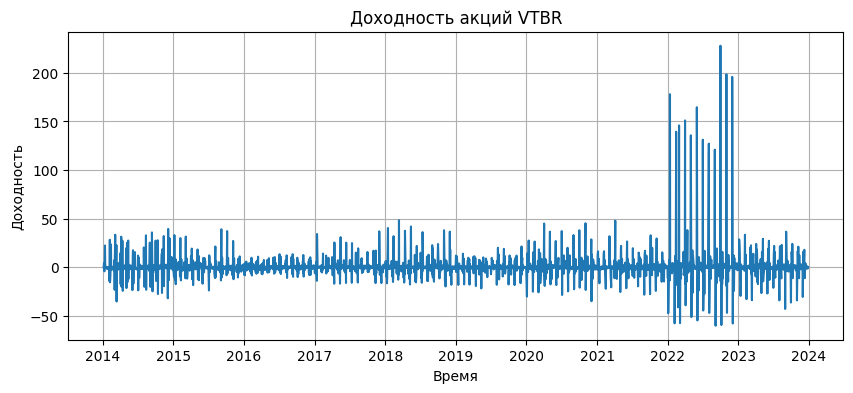

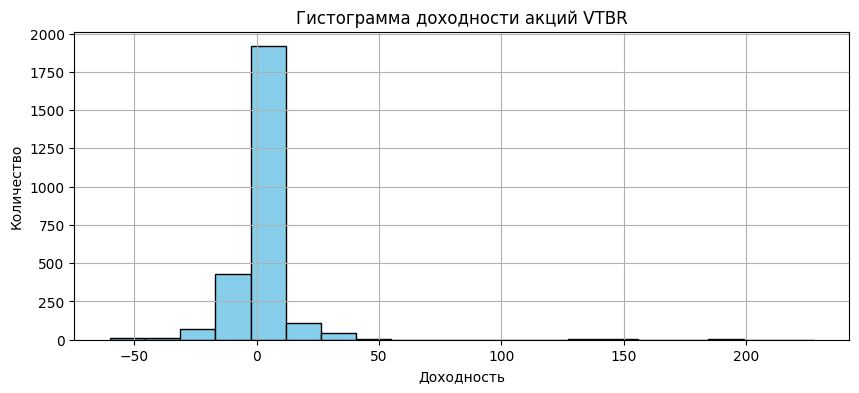

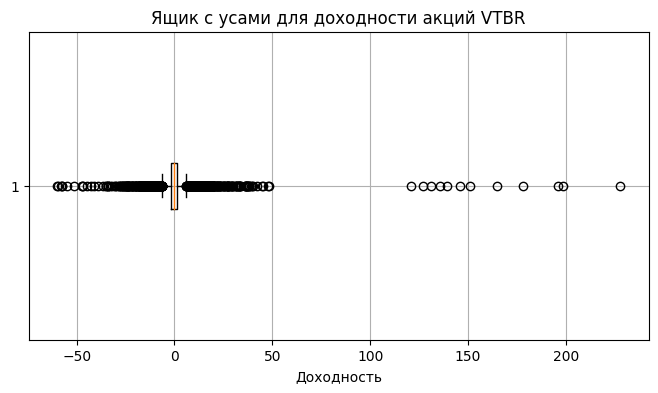

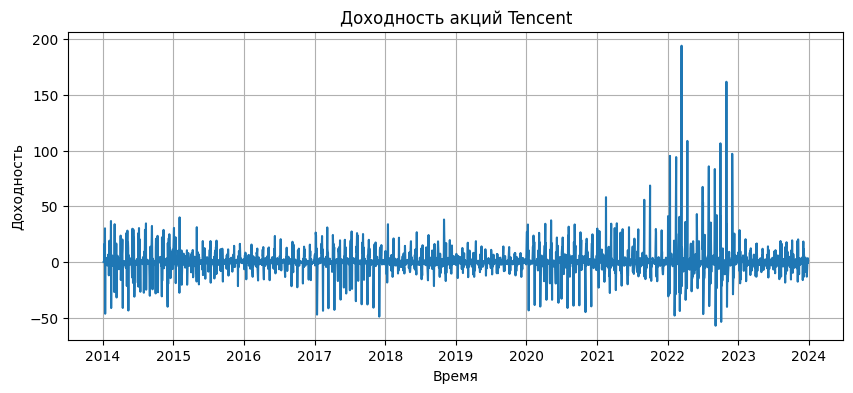

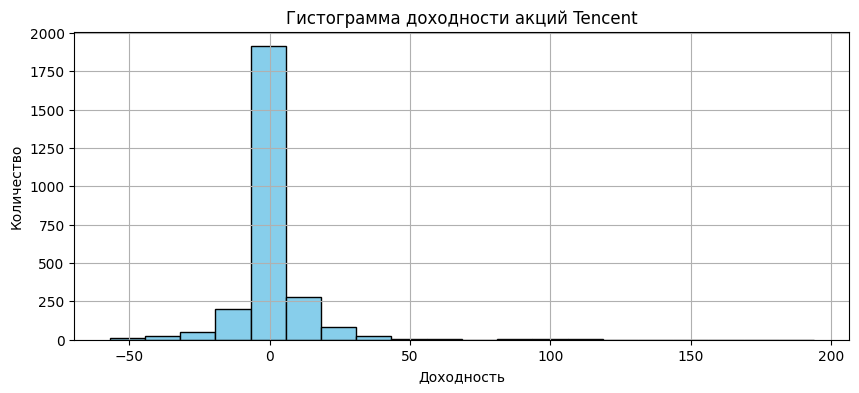

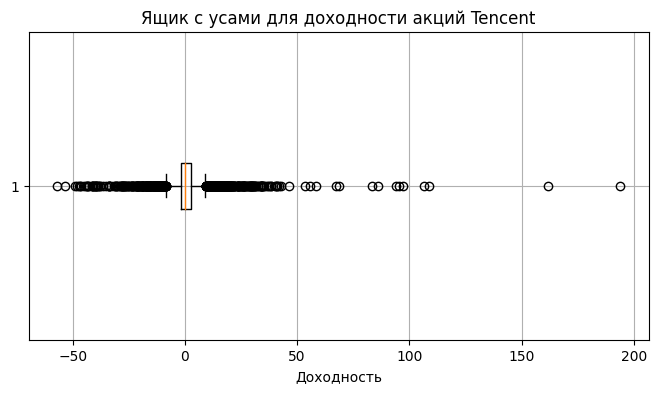

In [ ]:
cnt = ['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'VTBR' ,'Tencent']
df_reset = df_pct_change.reset_index()

#как параметр дохлдности можем использовать таблицу df_pct_change из прошлого пункта

for i in cnt:

    plt.figure(figsize=(10, 4))
    plt.plot(df_pct_change1['Дата'],df_pct_change1[i])
    plt.title(f'Доходность акций {i}')
    plt.xlabel('Время')
    plt.ylabel('Доходность')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 4))
    plt.hist(df_pct_change1[i], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Гистограмма доходности акций {i}')
    plt.xlabel('Доходность')
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()



    x=list(df_pct_change1[i].values)
    x1 = np.nan_to_num(x, nan=0)
    plt.figure(figsize=(8, 4))

    plt.boxplot(x1,vert=False)
    plt.title(f'Ящик с усами для доходности акций {i}')
    plt.xlabel('Доходность')
    plt.grid(True)
    plt.show()


__к) [5 баллов]__  В пункте __д)__ мы нашли даты, в которые наблюдались наибольшие измения стоимости ценых бумаг. При расчётах мы проигнорировали колебания курсов валют.

Давайте посмотрим, каким бы было колебание цен акций в абсолютном выражении для дат из таблички `top_5_diff`, если бы мы учли изменения курсов валют.

В таблице `df_pct_change` все доходности измерены в рублях. Посчитайте для этой таблицы построчное среднее для абсолютных значений изменений.

In [ ]:
# your code here
# =^･ｪ･^=
meann_change = df_pct_change.abs().mean(axis=1)*100
meann_change.head()

Дата
2014-01-04         NaN
2014-01-05    1.834124
2014-01-07    3.796870
2014-01-08    8.311250
2014-01-09    1.979919
dtype: float64

Оставьте только те даты, которые встречаются в `top_5_diff`, и добавить их в качестве нового столбца `'Изм. (RUB) %'`

__Hint__: Чтобы выделить список необходимых дат из таблички `top_5_diff`, можно воспользоваться методом `to_list()` применительно к столбцу `'Дата'`. Такой список можно дальше использовать при обращении к строкам в `'[...]'`.

In [ ]:

k = top_5_diff['Дата'].tolist()
values_for_dates = meann_change.loc[k]
val = []
for i in range(5):
  val.append(values_for_dates[i])
val


[12.677836687855622,
 1.6315866542303499,
 9.703503320473079,
 20.361101173722183,
 5.438385474702115]

In [ ]:
top_5_diff['Изм. (RUB) %'] = val

top_5_diff

,Дата,Изм. %,Изм. (RUB) %
0,2022-02-24,13.081429,12.677837
1,2016-02-29,11.840000,1.631587
2,2020-03-24,10.795714,9.703503
3,2020-12-03,10.615714,20.361101
4,2022-02-21,9.128000,5.438385


__л) [2 балла]__  Проинтерпретируете уменьшение/увеличение процентного изменения стоимости акций при пересчете по курсу в рубли.

__Ответ:__

## 3 Составляем портфель


Финансовые продукты описываются двумя характеристиками: __доходностью__ и __риском__.

Доходность — это процентное изменение стоимости за некоторый промежуток времени. Под риском, как правило, понимается стандартное отклонение доходности акций.

Однако когда речь идет о нескольких акциях в портфеле, то необходимо учитывать, как связана динамика цен на эти акции: падение доходности одной из акций может быть компенсировано ростом другой. Такой портфель будет предпочтительнее, поскольку предлагает меньшие риски для инвестора.

Осталось найти то самое сладкое сочетание активов... Для поиска оптимальных весов активов в портфеле обычно решается __задача оптимизации.__

Мы поступим проще:

- Будем рассматривать портфель, состоящий всего из 2 тикеров: `'AAPL'` и `'Tencent'`.
- Наилучшее сочетание весов будем искать неоптимальным способом, тупо перебирая различные варианты.

Пусть мы вкладываем долю нашего бюджета $w$ в первую ценную бумагу, а долю $(1 - w)$ во вторую. Тогда ожидаемая доходность порфеля составит

$$
\mathbb{E}(R) = w \cdot \mathbb{E}(R_1)  + (1 - w) \cdot \mathbb{E}(R_2).
$$

Дисперсия портфеля будет равна

$$
\text{Var}(R) = w^2 \cdot \text{Var}(R_1)  + (1 - w)^2 \cdot \text{Var}(R_2) + 2 \cdot w \cdot \text{Cov}(R_1, R_2).
$$

Ковариацию, по её определению, можно переписать как

$$
\text{Cov}(R_1, R_2) = \text{Corr}(R_1, R_2) \cdot \sigma(R_1) \cdot \sigma(R_2),
$$

где $\sigma(R_i) = \sqrt{ \text{Var}(R_i)}$.


Для начала создадим веса, которые будем рассматривать.

__а) [2 балла]__ С помощью функции `np.arange()` создайте `array` от $0$ до $1$ с шагом $0.01$ [(ссылка на документацию).](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)

In [ ]:
w = np.arange(0, 1.01, 0.01)
w


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

Теперь запишем необходимые характеристики акций в соответствующие переменные:

__б) [3 балла]__ В переменные `r1` и `r2` сохраните среднюю доходность акций `'AAPL'` и `'Tencent'` из `df_pct_change`. Убедитесь, что доходности представлены не в процентах, а в виде чисел. Например не $10\%$, а $0.1$.

Кроме того, поскольку стандартной мерой доходности является годовая доходность, преобразуем среднюю ежедневную доходность в годовую, используя формулу сложного процента для полученных значений:

$$
r_{\text{год}} = (1 + r_{\text{день}})^{252} - 1,
$$

где:
- $r_{\text{год}}$ - ожидаемая годовая доходность,
- $r_{\text{день}}$ - средняя ежедневная доходность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

In [ ]:
rr1 = df_pct_change1['AAPL'].mean()
rr2 = df_pct_change1['Tencent'].mean()

rr1 /= 100
rr2 /= 100
r1 = (1 + rr1) ** 252 - 1
r2 = (1 + rr2) ** 252 - 1

print(r1,r2)

6.197113555262046 5.657793414263677


__в) [3 балла]__ Аналогично сохраните стандартные отклонения доходности этих акций в `sd1` и `sd2`. Преобразуйте эти значения из дневных в годовые:

$$
\sigma_{\text{год}} = \sigma_{\text{день}} \times \sqrt{252}
$$

Где:
- $\sigma_{\text{год}}$ - годовая волатильность,
- $\sigma_{\text{день}}$ - ежедневная волатильность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

Эта формула основана на предположении, что ежедневные доходности распределены независимо и одинаково. В реальности рыночные условия могут влиять на точность этого преобразования, но это общепринятый метод для оценки годовой волатильности на основе ежедневных данных.

In [ ]:
sdd1 = df_pct_change1['AAPL'].std() / 100
sdd2 = df_pct_change1['Tencent'].std() / 100

sd1 = sdd1 * (252 ** 0.5)
sd2 = sdd2 * (252 ** 0.5)

print(sd1, sd2)


1.779733952189021 1.9601882134585562


__в) [1 балл]__ В переменную `rho` сохраните корреляцию между акциями.

In [ ]:
rho = df_pct_change1[['AAPL', 'Tencent']].corr().iloc[0, 1]
rho

0.5593078697724105

Теперь посчитаем доходность и волатильность портфеля, используя соответствующие формулы

In [ ]:
r_p2 = w * r1 +(1 - w) * r2
sd_p2 = np.sqrt(w**2 * sd1**2 + (1 - w)**2 * sd2**2 + 2 * w * (1 - w) * rho * sd1 * sd2)

__г) [5 баллов]__ Постройте линейный график в осях (`sd_p2`, `r_p2`)

__Hint:__ Можно сделать с помощью `plt.plot(x, y)`

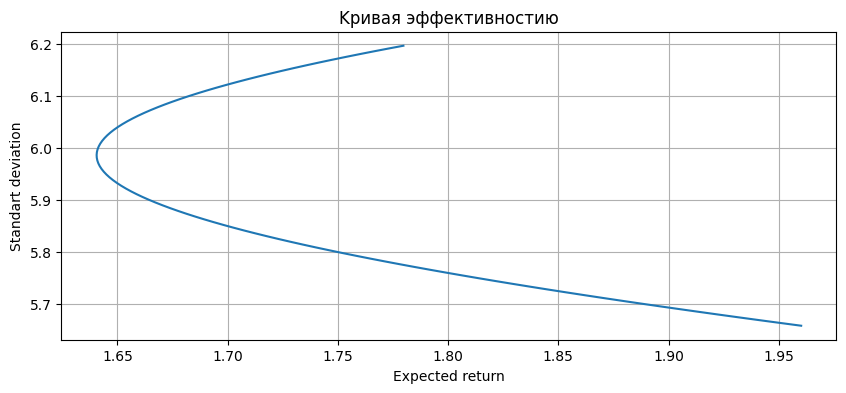

In [ ]:
# your code here
# ┌(ಠ_ಠ)┘
plt.figure(figsize=(10, 4))
plt.plot(sd_p2, r_p2)
plt.title(f'Kривая эффективностию')
plt.xlabel('Expected return')
plt.ylabel('Standart deviation')
plt.grid(True)
plt.show()

Получившаяся у вас картинка должна быть похожа на такую:

<center>
<img src="https://investprofit.info/wp-content/uploads/2018/08/Frontier1.png" height="450">
</center>

В портфельной теории Марковица эта кривая называется эффективной границей (или кривой эффективностию). Её можно поделить на три зоны:

- **Эффективная граница (Efficient Frontier)** — это часть кривой, которая лежит выше портфеля с минимальной дисперсией (риском). Портфели на этом участке предлагают наилучшее сочетание риска и доходности. Другими словами, для любого данного уровня риска, портфели на эффективной границе предлагают максимальную возможную доходность.
- **Портфели ниже эффективной границы** считаются неэффективными, так как для того же уровня риска можно добиться большей доходности.
- **Портфели выше эффективной границы** обычно не существуют, так как они предполагали бы получение более высокой доходности при том же уровне риска.

Найдем портфель с минимальной дисперсией (риском).

__д) [3 балла]__ Для этого сначала создадим табличку со столбцами `'Вес'`, `'Риск'` и `'Доходность'` (содержащими `w`, `sd_p2` и `r_p2` соответственно)

In [ ]:
data = {
    'Вес': w,
    'Риск': sd_p2,
    'Доходность': r_p2
}
df_r = pd.DataFrame(data)
df_r.head()


,Вес,Риск,Доходность
0,0.00,1.960188,5.657793
1,0.01,1.950596,5.663187
2,0.02,1.941117,5.668580
3,0.03,1.931752,5.673973
4,0.04,1.922503,5.679366


__е) [3 балла]__ Теперь найдем портфель с минимальным риском и запишем его в переменную `min_sd_p`, а само значение минимального риска в `min_sd`

In [ ]:
min_sd_p = df_r['Риск'].idxmin()
min_sd_p = df_r.loc[min_sd_p]

min_sd = min_sd_p['Риск']

print(min_sd)
print(min_sd_p)

1.6405529747308192
Вес           0.610000
Риск          1.640553
Доходность    5.986779
Name: 61, dtype: float64


__ж) [3 балла]__ Выберем множество эффективных портфелей из `df_r`, тех, чья доходность и риск выше, чем у `min_sd_p` и сохраним их в `df_eff_p`

In [ ]:
df_eff_p = df_r[(df_r['Доходность'] > min_sd_p['Доходность']) & (df_r['Риск'] > min_sd_p['Риск'])]
df_eff_p.head()


,Вес,Риск,Доходность
62,0.62,1.640674,5.992172
63,0.63,1.640985,5.997565
64,0.64,1.641485,6.002958
65,0.65,1.642174,6.008352
66,0.66,1.643052,6.013745


__з) [3 балла]__ А теперь на основе `df_eff_p` построим эффективную границу, о которой шла речь раньше (часть кривой выше портфеля с наименьшей волатильностью)

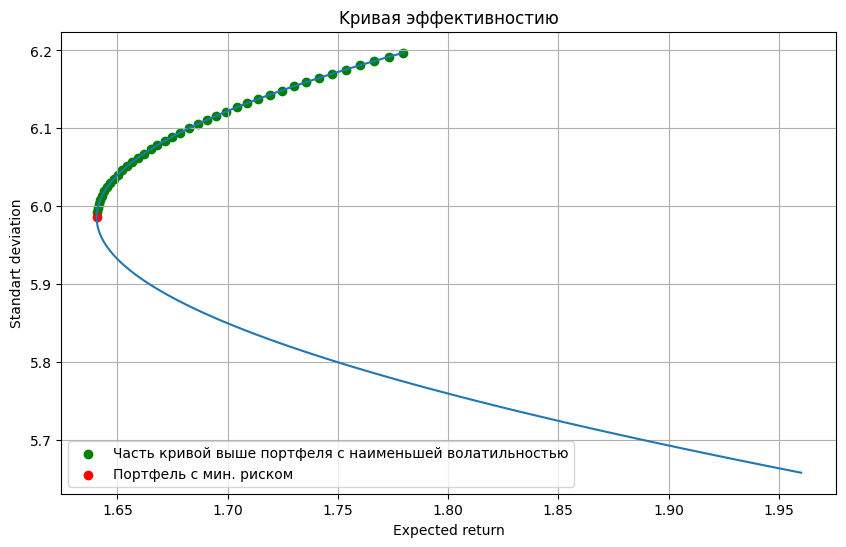

In [ ]:
# your code here
# [✖‿✖]
plt.figure(figsize=(10, 6))

plt.plot(sd_p2, r_p2)
plt.scatter(df_eff_p['Риск'], df_eff_p['Доходность'], color ='green', label='Часть кривой выше портфеля с наименьшей волатильностью')
plt.scatter(min_sd_p['Риск'], min_sd_p['Доходность'], color ='red', label='Портфель с мин. риском')

plt.title(f'Kривая эффективностию')
plt.xlabel('Expected return')
plt.ylabel('Standart deviation')

plt.legend()
plt.grid(True)
plt.show()


Выше мы говорили, что для поиска оптимального портфеля необходимо решать задачу оптимизации. Целевую функцию для её решения можно определить по-разному. Выше мы занимались минимизацией риска и нашли `min_sd_p`.

Кроме минимизации риска можно попытаться максимизировать **коэффициент Шарпа.** Он рассчитывается по формуле

$$
SR = \frac{r_{p} - r_{f}}{\sigma_{p}},
$$

где $r_{p}$  —  ожидаемая доходность портфеля, $r_{f}$  —  безрисковая ставка доходности, $\sigma_{p}$ — стандартное отклонение доходности портфеля.

Коэффициент Шарпа отражает премию за принятый риск. Любая инвестиционная стратегия, демонстрирующая более крутой наклон кривой Шарпа, предлагает более высокую ожидаемую доходность для данного уровня риска. Следовательно, более высокий коэффициент Шарпа всегда предпочтительнее, независимо от того, какой уровень риска вы готовы принять.

В качестве безрисковой ставки доходности выберем доходность российских государственных облигаций сроком 10 лет (можно посмотреть [тут](https://cbr.ru/hd_base/zcyc_params/))

In [ ]:
r_f = 11.8/100

__и) [3 балла]__ Теперь у нас есть возможность рассчитать коэффициент Шарпа для кадждого портфеля в `df_r`. Для этого необходимо вычесть из доходности портфеля безрисковую ставку (`r_f`) и разделить на волатильность (риск) портфеля. Сохраните полученные значения в столбец `'Sharp'` таблицы `df_r`

In [ ]:
df_r['Sharp'] = (df_r['Доходность'] - r_f) / df_r['Риск']
df_r.head()

,Вес,Риск,Доходность,Sharp
0,0.00,1.960188,5.657793,2.826154
1,0.01,1.950596,5.663187,2.842816
2,0.02,1.941117,5.668580,2.859477
3,0.03,1.931752,5.673973,2.876131
4,0.04,1.922503,5.679366,2.892773


__и) [3 балла]__ Определите портфель с максимальным коэффициентом Шарпа, сохраните его в переменную `max_sharp_p`, а значение самого коэффициента - в переменную `max_sharp`

In [ ]:
max_sharp_p = df_r['Sharp'].idxmax()
max_sharp_p = df_r.loc[max_sharp_p]
max_sharp = max_sharp_p['Sharp']
print(max_sharp_p)
print(max_sharp)

Вес           0.690000
Риск          1.646815
Доходность    6.029924
Sharp         3.589914
Name: 69, dtype: float64
3.589913673201108


Рассмотрим прямую в осях (Риск - Доходность), выраженную формулой

$$ r = max\_sharp \cdot \sigma + r_f $$

Для того, чтобы ее провести, нам необходимо задать хотя бы 2 точки. Чтобы построенный график хорошо выглядел, рассмотрим $\sigma$, равную:

1. наименьшему значению риска портфелей на эффективной кривой (`min_sd`)
2. значению риска, соответствующего портфелю с наибольшим значением коэффициента Шарпа (из `max_sharp_p`)

__к) [3 балла]__ В переменную `sigma` сохраните `numpy.array` с двумя перечисленными выше значениями

In [ ]:
sigma = np.array([min_sd, max_sharp_p['Риск']])
print(sigma)

[1.64055297 1.64681517]


__л) [3 балла]__ В переменную `r` сохраните значения доходности, находящиеся на указанной прямой, для значений риска из `sigma` (необходимо использовать формулу прямой)

In [ ]:
r = max_sharp * sigma + r_f
print(r)

[6.00744356 6.02992431]


__м) [5 баллов]__ Теперь построим эффективную границу, что мы уже делали ранее, и проведем указанную прямую (вернее ее часть).

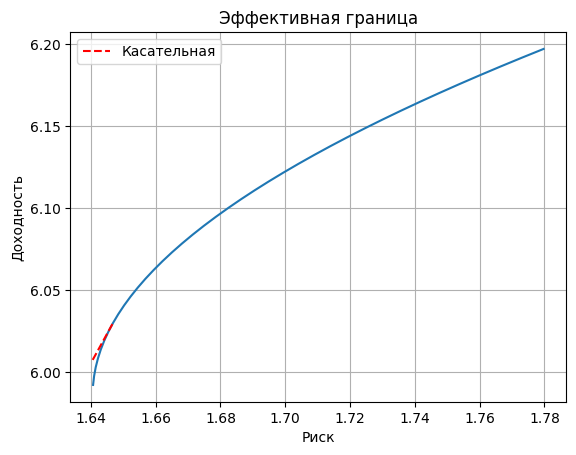

In [ ]:
# your code here
# [̲̅$̲̅(̲̅5̲̅)̲̅$̲̅]
plt.plot(df_eff_p['Риск'], df_eff_p['Доходность'], linestyle='-')
plt.plot(sigma, r, color='red', linestyle='--', label='Касательная')

plt.xlabel('Риск')
plt.ylabel('Доходность')
plt.title('Эффективная граница')
plt.legend()

plt.grid(True)
plt.show()


Полученная прямая является касательной к эффективной кривой, а точка ее касания представляет собой так называемый тангенциальный портфель.

Каждая точка на прямой Шарпа представляет собой портфель, состоящий из комбинации безрискового актива (в нашем случае, государственных облигаций) и рыночного портфеля (здесь, сочетание двух акций).

Все портфели на прямой Шарпа считаются эффективными в смысле оптимального соотношения риска и доходности. Это означает, что для любого данного уровня риска портфель на этой линии предоставляет максимально возможную доходность.

__н) [3 балла]__ Проинтерпретируйте численное значение наибольшего коэффициента Шарпа (`max_sharp`)

**Ответ:** Портфель с данным значением обеспечивает наибольшую премию. В нашем случае: 3.5899136732011057, что значает, что вероятность получения убытка от инвестиций не превышает 1%

Таким образом, мы немного углубились в портфельную теорию и рассмотрели 2 основных метода оптимизации структуры портфеля:
- поиск наименее волатильного (рискового) портфеля
- поиск портфеля с оптимальным соотношением доходности и риска.